In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import os
import cv2

In [37]:

from tensorflow.keras.layers import Input, Lambda, Dense, Flatten
from tensorflow.keras.models import Model
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator,load_img
from tensorflow.keras.layers import Input, UpSampling2D, Flatten, BatchNormalization, Dense, Dropout, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
import numpy as np
from glob import glob
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import ImageDataGenerator, load_img, img_to_array
import tensorflow as tf
from tensorflow.keras.preprocessing import image

In [4]:
# re-size all the images to this
IMAGE_SIZE = [224, 224]

train_path = '/content/drive/MyDrive/p/Datasets/Datasets/Train'
valid_path = '/content/drive/MyDrive/p/Datasets/Datasets/valid'
num_classes=4


In [5]:
resnet = ResNet50(input_shape=(224, 224, 3), weights='imagenet', include_top=False)

94781440/94765736 [==============================] - 1s 0us/step


In [6]:
resnet.summary()

Model: "resnet50"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                           

In [7]:
# Working on pretrained model.
last_layer = resnet.get_layer("conv5_block3_add")
print(f"The shape of last output layer is {last_layer.output_shape}")
last_output = last_layer.output

The shape of last output layer is (None, 7, 7, 2048)


In [8]:
# Processing the Model

# Flatten the output layer of pretrained model into 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Adding fully connected layer with relu activation
x = tf.keras.layers.Dense(units=1024, activation="relu")(x)
# Adding dropout with rate 0.2
x = tf.keras.layers.Dropout(0.2)(x)
# Adding final sigmoid layer for activation
x = tf.keras.layers.Dense(4, activation="softmax")(x)

# Preparing the final Model
model = Model(resnet.input, x)

In [9]:
# Compile the Model
model.compile(loss="categorical_crossentropy",
              optimizer='adam',
              metrics=["accuracy"])

In [10]:
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 224, 224, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 230, 230, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 112, 112, 64  9472        ['conv1_pad[0][0]']              
                                )                                                                 
                                                                                              

In [11]:
# Normalizing all the images
# All images are rescaled by 1./255
train_datagen = ImageDataGenerator(rescale=1./255,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,
                                   fill_mode="nearest")

validation_datagen = ImageDataGenerator(rescale=1./255)

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
    train_path,
    target_size=(224, 224),
    batch_size=128,
    class_mode="categorical"
)

# Flow validation images in batches of 32 using validation_datagen generator
validation_generator = validation_datagen.flow_from_directory(
    valid_path,
    target_size=(224, 224),
    batch_size=32, 
    class_mode="categorical"
)

Found 81 images belonging to 4 classes.
Found 69 images belonging to 4 classes.


In [18]:
# Training the Model
history = model.fit_generator(
    train_generator,
    steps_per_epoch=len(train_generator), 
    epochs=100,
    validation_data=validation_generator,
    validation_steps=len(validation_generator)
)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 1.4154 - accuracy: 0.9506 - val_loss: 11.4961 - val_accuracy: 0.4203
Epoch 2/100
1/1 [==============================] - 2s 2s/step - loss: 0.0748 - accuracy: 0.9753 - val_loss: 11.4736 - val_accuracy: 0.3913
Epoch 3/100
1/1 [==============================] - 2s 2s/step - loss: 0.2108 - accuracy: 0.9877 - val_loss: 11.5521 - val_accuracy: 0.2029
Epoch 4/100
1/1 [==============================] - 2s 2s/step - loss: 6.2961e-04 - accuracy: 1.0000 - val_loss: 12.4490 - val_accuracy: 0.1594
Epoch 5/100
1/1 [==============================] - 2s 2s/step - loss: 0.3744 - accuracy: 0.9753 - val_loss: 13.0460 - val_accuracy: 0.1594
Epoch 6/100
1/1 [==============================] - 2s 2s/step - loss: 1.2284 - accuracy: 0.9506 - val_loss: 13.4733 - val_accuracy: 0.1594
Epoch 7/100
1/1 [==============================] - 2s 2s/step - loss: 1.1320e-04 - accuracy: 1.0000 - val_loss: 13.7080 - val_accuracy: 0.1594
Epoch 8/100
1/1 [==

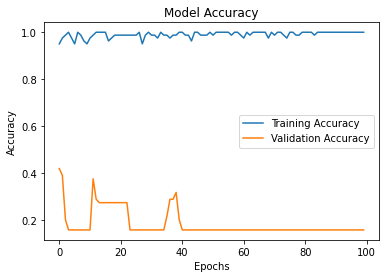

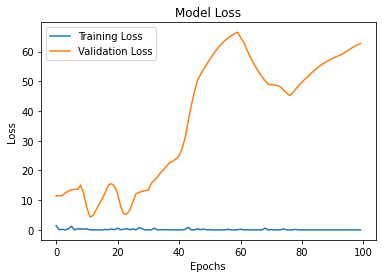

In [20]:
plt.subplot()
plt.title('Model Accuracy')
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.ylabel('Accuracy')
plt.xlabel('Epochs')
plt.legend(['Training Accuracy','Validation Accuracy'])
plt.savefig('baseline_acc_epoch.png', transparent= False, bbox_inches= 'tight')
plt.show()

plt.title('Model Loss')
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('Loss')
plt.xlabel('Epochs')
plt.legend(['Training Loss','Validation Loss'])
plt.savefig('baseline_loss_epoch.png', transparent= False, bbox_inches= 'tight')
plt.show()

In [21]:
%cd

/root


In [22]:
%cd /content/drive/MyDrive/nlp/final/cv

/content/drive/MyDrive/nlp/final/cv


In [23]:
# save it as a h5 file


from tensorflow.keras.models import load_model

model.save('model_resnet50.h5')

In [24]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing import image

In [25]:
model=load_model('model_resnet50.h5')

In [26]:
filename="/content/Audi_A6_e_tron_Renderbild_Front.jpg"

In [34]:
width=224
height=224
dim=(width,height)


In [35]:
image = cv2.imread(filename)
resized = cv2.resize(image, dim, interpolation=cv2.INTER_AREA)
            


In [38]:
x=image.img_to_array(resized)
x

array([[[221., 215., 208.],
        [221., 215., 208.],
        [221., 215., 208.],
        ...,
        [226., 226., 226.],
        [226., 226., 226.],
        [226., 226., 226.]],

       [[221., 215., 208.],
        [221., 215., 208.],
        [221., 215., 208.],
        ...,
        [226., 226., 226.],
        [226., 226., 226.],
        [226., 226., 226.]],

       [[221., 215., 208.],
        [221., 215., 208.],
        [221., 215., 208.],
        ...,
        [226., 226., 226.],
        [226., 226., 226.],
        [226., 226., 226.]],

       ...,

       [[201., 189., 187.],
        [201., 189., 187.],
        [201., 189., 187.],
        ...,
        [214., 202., 200.],
        [212., 200., 198.],
        [214., 202., 200.]],

       [[201., 189., 187.],
        [201., 189., 187.],
        [201., 189., 187.],
        ...,
        [216., 207., 204.],
        [215., 207., 204.],
        [216., 208., 205.]],

       [[201., 189., 187.],
        [201., 189., 187.],
        [201., 1

In [39]:
x.shape

(224, 224, 3)

In [40]:
x=x/255

In [41]:
x=np.expand_dims(x,axis=0)
img_data=preprocess_input(x)
img_data.shape

(1, 224, 224, 3)

In [42]:
model.predict(img_data)

array([[2.5572666e-21, 6.0854602e-19, 9.6185097e-33, 1.0000000e+00]],
      dtype=float32)

In [44]:
a=np.argmax(model.predict(img_data), axis=1)
a

array([3])